In [1]:
# Import all the necessary Library
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
# First, look at everything.
from subprocess import check_output
print(check_output(["ls", "/content/drive/MyDrive/Mini Project/sign_data"]).decode("utf8"))

test
test_data.csv
train
train_data.csv



In [4]:
class Config():
    training_dir = "/content/drive/MyDrive/Mini Project/sign_data/train"
    testing_dir = "/content/drive/MyDrive/Mini Project/sign_data/test"
    train_batch_size = 32
    train_number_epochs = 30

In [5]:
training_dir="/content/drive/MyDrive/Mini Project/sign_data/train"
training_csv="/content/drive/MyDrive/Mini Project/sign_data/train_data.csv"
testing_dir="/content/drive/MyDrive/Mini Project/sign_data/test"
testing_csv="/content/drive/MyDrive/Mini Project/sign_data/test_data.csv"

In [6]:
class SiameseNetworkDataset():

    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir
        self.transform = transform

    def __getitem__(self,index):

        # getting the image path
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])


        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))

    def __len__(self):
        return len(self.training_df)

In [7]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseNetworkDataset(training_csv,training_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

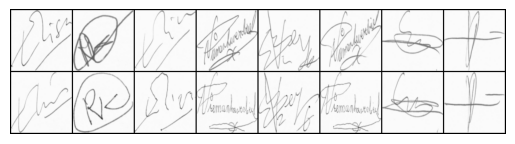

[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]]


In [8]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(

            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )

        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),

            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128,2))



    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [10]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive


In [11]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
# Check whether you have GPU is loaded or not
if torch.cuda.is_available():
    print('Yes')

Yes


In [13]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.9)


In [18]:
def train():
    counter = []
    loss_history = []
    iteration_number= 0

    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %50 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    return net

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
model = train()
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/signature.pt")  # Save to desired path
print("Model Saved Successfully to Google Drive")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d

Epoch number 0
 Current loss 1.8683831691741943

Epoch number 0
 Current loss 1.2581913471221924

Epoch number 0
 Current loss 1.1984524726867676

Epoch number 0
 Current loss 1.0363976955413818

Epoch number 0
 Current loss 1.548272967338562

Epoch number 0
 Current loss 1.339271903038025

Epoch number 0
 Current loss 1.2643730640411377

Epoch number 0
 Current loss 1.3522844314575195

Epoch number 0
 Current loss 1.1926243305206299

Epoch number 0
 Current loss 1.5732173919677734

Epoch number 0
 Current loss 1.1656399965286255

Epoch number 0
 Current loss 1.221099615097046

Epoch number 0
 Current loss 1.0205883979797363

Epoch number 0
 Current loss 1.1246927976608276

Epoch number 0
 Current loss 1.2238285541534424



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch number 1
 Current loss 1.398120641708374

Epoch number 1
 Current loss 0.993117094039917

Epoch number 1
 Current loss 1.0750725269317627

Epoch number 1
 Current loss 1.0491034984588623

Epoch number 1
 Current loss 1.2004077434539795

Epoch number 1
 Current loss 1.1656773090362549

Epoch number 1
 Current loss 1.007670283317566

Epoch number 1
 Current loss 1.1659836769104004

Epoch number 1
 Current loss 1.0626213550567627

Epoch number 1
 Current loss 1.6741130352020264

Epoch number 1
 Current loss 1.2794444561004639

Epoch number 1
 Current loss 1.2558708190917969

Epoch number 1
 Current loss 1.1595538854599

Epoch number 1
 Current loss 1.1896578073501587

Epoch number 1
 Current loss 1.0934498310089111

Epoch number 2
 Current loss 1.1897631883621216

Epoch number 2
 Current loss 1.2187354564666748

Epoch number 2
 Current loss 0.9050931334495544

Epoch number 2
 Current loss 1.275277853012085

Epoch number 2
 Current loss 1.4894001483917236

Epoch number 2
 Current los

In [19]:
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

NameError: name 'model' is not defined

In [ ]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("model.pt"))

In [ ]:
# Load the test dataset
test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=testing_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)


In [ ]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0):
  x0, x1 , label = data
  concatenated = torch.cat((x0,x1),0)
  output1,output2 = model(x0.to(device),x1.to(device))
  eucledian_distance = F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Orginial"
  else:
    label="Forged"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1
  if counter ==20:
     break

In [15]:
# import torch
# from torch.utils.data import DataLoader

# def train(net, criterion, optimizer, train_dataloader, epochs, device="cuda:0" if torch.cuda.is_available() else "cpu"):
#     """Trains the Siamese network for signature verification.

#     Args:
#         net (torch.nn.Module): The Siamese network architecture.
#         criterion (torch.nn.Module): The loss function (e.g., ContrastiveLoss).
#         optimizer (torch.optim.Optimizer): The optimizer used for training (e.g., Adam).
#         train_dataloader (DataLoader): The data loader for training data.
#         epochs (int): The number of epochs to train for.
#         device (str, optional): The device to use for training (CPU or GPU). Defaults to "cuda:0" if available, otherwise "cpu".

#     Returns:
#         torch.nn.Module: The trained Siamese network.
#     """

#     counter = []
#     loss_history = []
#     accuracy_history = []

#     for epoch in range(epochs):
#         print(f"Epoch {epoch+1}/{epochs}")  # Clearer epoch numbering
#         running_loss = 0.0
#         running_corrects = 0

#         for i, data in enumerate(train_dataloader, 0):
#             img0, img1, label = data
#             img0, img1, label = img0.to(device), img1.to(device), label.to(device)
#             optimizer.zero_grad()
#             output1, output2 = net(img0, img1)
#             loss_contrastive = criterion(output1, output2, label)
#             loss_contrastive.backward()
#             optimizer.step()

#             # Calculate accuracy (assuming label is 1 for similar, 0 for dissimilar)
#             predicted = torch.argmax(output1 - output2, dim=1)
#             running_corrects += (predicted == label).float().sum().item()
#             running_loss += loss_contrastive.item()

#             if i % 50 == 0:
#                 accuracy = running_corrects / (len(train_dataloader.dataset) * label.size(0))
#                 print(f"\tBatch {i+1}/{len(train_dataloader)} - Loss: {loss_contrastive.item():.4f}, Accuracy: {accuracy:.4f}")

#         epoch_loss = running_loss / len(train_dataloader.dataset)
#         epoch_accuracy = running_corrects / (len(train_dataloader.dataset) * label.size(0))

#         counter.append(epoch + 1)  # Epoch number for accurate plotting
#         loss_history.append(epoch_loss)
#         accuracy_history.append(epoch_accuracy)

#         print(f"\tEpoch {epoch+1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

#     # Plot loss and accuracy (assuming you have a plotting library like matplotlib)
#     import matplotlib.pyplot as plt

#     plt.figure(figsize=(10, 6))
#     plt.plot(counter, loss_history, label='Loss')
#     plt.plot(counter, accuracy_history, label='Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss/Accuracy')
#     plt.title('Training Loss and Accuracy')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     return net
